In [138]:
import pandas as pd
import numpy as np
import json
import math

from tqdm.notebook import tqdm
from scipy.stats import expon
from matplotlib import pyplot as plt


In [139]:
with open('dados.json') as file:
    dados = json.load(file)['dados']

dados = pd.DataFrame(dados)

In [140]:

media = np.mean(dados['por dia'])
precisao_x = 1
delta_x = 10 ** (-1 * precisao_x)
x_max = np.max(dados['por dia'])
lista_x = list()
for x in np.arange(0, x_max, delta_x): lista_x.append(round(x, precisao_x))
    
valor_expon = list()
for x in lista_x:
    valor = expon.pdf(x, scale=media)
    valor_expon.append(valor)


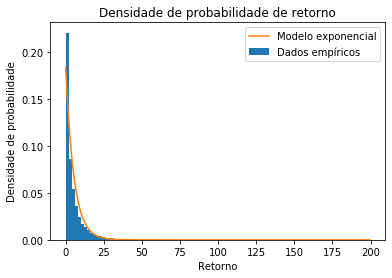

In [141]:
plt.hist(dados['por dia'], bins=100, density=True)
plt.plot(lista_x, valor_expon)
plt.title('Densidade de probabilidade de retorno')
plt.legend(['Modelo exponencial', 'Dados empíricos'])
plt.xlabel('Retorno')
plt.ylabel('Densidade de probabilidade')
plt.show()


[0.03044085 4.82834983]


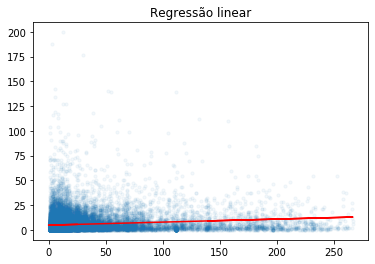

In [146]:
dados = dados.loc[:, ['hotspots proximos', 'por dia']]

filtro = pd.notnull(dados['hotspots proximos'])
dados = dados.loc[filtro, :]


filtro = pd.notnull(dados['por dia'])
dados = dados.loc[filtro, :]

dados_x = np.array(dados['hotspots proximos'])
dados_y = np.array(dados['por dia'])

plt.scatter(dados_x, dados_y, alpha=.05, s=10)

betas = np.polyfit(dados_x, dados_y, 1)
trend = np.poly1d(betas)
plt.plot(dados_x, trend(dados_x), 'r')

plt.title('Regressão linear')

print(betas)

plt.show()